# Portfolio Optimization and Allocation

## Project Abstract

파이썬을 사용하여 Portfolio Optimization과 Allocation을 할 수 있는 방법을 소개하고 실습해보고자 합니다.

다양한 Portfolio Optimization Strategy를 적용하고 그 결과를 확인해보고자 합니다.
- MPT(Modern Portfolio Theory) : 주어진 Risk에서 Return을 최대화 하려는 전략입니다. 

**@jhbale11**

## Basics of the Model

Portfolio Optimization을 하고자 할 때 필요한 개념은 아래와 같습니다.

### 1. Porfolio Expected Return
$$
E(R_p) = \sum_{i} w_iE(R_i)
$$
- $R_p$ : Total return of portfolio
- $w_i$ : Weight of each asset
- $R_i$ : Return of each asset

**Expected Return**은 각각의 자산의 Weight와 그것들의 Return을 곱한 것들의 합으로 계산됩니다.

### 2. Portfolio Variance
$$
\sigma_p^2 = \sum_{i} w_i^2\sigma_i^2~+~\sum_{i}\sum_{j\not=i} w_iw_j\sigma_i\sigma_j\rho_{ij}
$$
- $w_i$ : The portfolio weight of the first asset
- $w_j$ : The portfolio weight of the second asset
- $σ_i$ : The standard deviation of the first asset
- $σ_j$ : The standard deviation of the second asset
- $\rho_{ij}$ : The covariance of the two assets, which can thus be expressed as $\rho_{ij}$σ1σ2, where $\rho_{ij}$ is the correlation coefficient between the two assets

**Portfolio Variance**는 모델에 잠재하는 리스크를 측정하기 위한 지표입니다. Variance가 높을수록 Portfolio에 잠재된 위험이 크다는 의미입니다.

### 3. Sharpe Ratio

$$
\frac {R_p - R_f}{\sigma_p}
$$
- $R_p$ : Return of Portfolio
- $R_f$ : Risk-Free Rate
- $\sigma_p$ : Standard Deviation of the portfolio's excess return

**Sharpe Ratio**는 금융에서 투자 성과를 평가함에 있어 해당 투자의 위험을 조정해 반영하는 방식입니다. Sharpe Ratio는 투자 자산 또는 매매 전략에서 위험이라 불리는 편차 한 단위 당 초과수익을 측정합니다. 즉 투자자가 부담하는 위험을 자산 수익률이 얼마나 잘 보상하는지를 규정하는 지표로서 Sharpe Ratio가 더 높을수록 동일한 위험에 대해 더 높은 수익률을 제공한다는 것을 의미합니다.

### 4. The Efficient Frontier -

**효율적 투자선 (Efficient Frontier)** 는 Harry Markowitz 등이 발표한  Modern Portfolio Theory에서 소개된 개념입니다.  다음 그림의 원형 점들은 서로 다른 위험 (투자수익률의 표준편차 standard deviation 으로 측정)과 수익률로 구성된 개별 주식들이며 각각의 기대수익률과 위험을 그래프상에 표시한 것입니다. 일반적으로 기대수익률은 투자에 따른 위험과 비례하게 되므로 기대수익률이 높으면 그만큼 큰 위험을 감수해야 합니다. 

![wikepedia - Efficient Frontier](https://upload.wikimedia.org/wikipedia/commons/e/e1/Markowitz_frontier.jpg)

투자를 위해 대상 주식을 선택할 때 동일한 위험을 가진 주식 중에서는 기대수익률이 높은 것이 선택되고, 동일한 기대수익률을 가진 주식들 중에서는 위험이 가장 낮은 주식이 선택됨이 당연할 것인데 이를 **지배원리 (Principle of Dominance)**라 합니다. **‘효율적 투자선’** 은 지배원리에 따라 가장 우수한 주식투자들을 선정하여 연결해 놓은 선으로서 아래 곡선 중 변곡점부터의 우상향 곡선을 말하며 이를 **‘Markowitz Bullet'** 이라고도 부릅니다.

Risk-free Asset (무위험 자산, 미국 정부채를 무위험 자산으로 간주함)을 제외하고 Risky Asset인 주식에 투자할 때는 위에서 말한 곡선의 Efficient Frontier 선상에 존재하는 주식 중에서 자신의 위험선호도를 고려하여 하나를 선택하게 되지만 Risk-free Asset을 포함하여 포트폴리오를 구성하게 되면 변곡점과 Risk-free 투자안을 연결하는 직선이 새로운 ‘효율적 투자선’이 되며 이 선을 **‘자본 배분선 (CAL: Capital Allocation Line)'**이라 합니다.  

투자자가 투자수익률을 극대화 하는 과정에서 Risk-free Asset과 Risky Asset간의 배분은 **자본 배분선인 CAL 위에서** 이루어진다는 의미입니다.

## Automating Portfolio Optimization in Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib.ticker import FuncFormatter

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.cla import CLA
from pypfopt import discrete_allocation
from pypfopt import objective_functions
from matplotlib.ticker import FuncFormatter

### 1. Load Data with yfinance

yfinance로 데이터를 불러옵니다. 이번 실습에서 다루게 될 자산 항목은 나스닥 주식 및 ETF입니다. 각각의 Ticker에 대한 설명은 아래와 같습니다.
- BSX : 중재적 방사선학, 중재적 심장학, 말초 중재술 등 중재적 의료 전문 분야에 사용되는 의료 기기 기업
- AES : 전력 생산 및 분배 전력 회사
- BRK-B : 워렌 버핏의 투자 목적 지수회사 버크셔해서웨이
- SEE : 식품 포장 및 버블 랩 완충 포장과 같은 포장 회사
- QQQ : 기초 자산으로 만들어진 ETF
- SPY : S&P500 ETF

In [3]:
# Set the start and end date
start_date = '2015-01-01'
end_date = '2022-03-15'

# Define the ticker list
tickers_list = ['BSX','AES','BRK-B','SEE','QQQ','SPY']

# Create placeholder for data
data = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    data[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']
    
# Print first 5 rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BSX,AES,BRK-B,SEE,QQQ,SPY
Date,,,,,,
2014-12-31,13.25,10.564453,150.149994,38.254536,97.376854,179.880432
2015-01-02,13.22,10.510746,149.169998,38.497959,97.084488,179.784149
2015-01-05,13.81,10.211535,147.000000,37.947998,95.660378,176.537292
2015-01-06,13.70,9.981374,146.839996,38.146351,94.377731,174.874496
2015-01-07,14.03,9.996720,148.880005,38.200443,95.594353,177.053619


### 2. Preprocessing

데이터에 결측치가 있는지 확인합니다.

In [4]:
nullin_df = pd.DataFrame(data, columns=tickers_list)
print(nullin_df.isnull().sum())

BSX      0
AES      0
BRK-B    0
SEE      0
QQQ      0
SPY      0
dtype: int64


### 3. Calculations

먼저 Expected Return과 Portfolio Variance를 계산합니다.

In [5]:
#Annualized Return
mu = expected_returns.mean_historical_return(data)
print(mu)

#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(data)
print(Sigma)

BSX      0.173643
AES      0.105431
BRK-B    0.115726
SEE      0.079050
QQQ      0.178792
SPY      0.123558
dtype: float64
            BSX       AES     BRK-B       SEE       QQQ       SPY
BSX    0.080249  0.038136  0.030152  0.034427  0.034307  0.032764
AES    0.038136  0.105645  0.031476  0.046304  0.031079  0.032810
BRK-B  0.030152  0.031476  0.040342  0.029157  0.027298  0.029085
SEE    0.034427  0.046304  0.029157  0.093925  0.023995  0.027023
QQQ    0.034307  0.031079  0.027298  0.023995  0.045429  0.034948
SPY    0.032764  0.032810  0.029085  0.027023  0.034948  0.031644


Portfolio Weight와 함께 최대 Sharpe Ratio와 최소 Volatility를 각각 계산합니다.

### Max Sharpe Ratio Analysis

Efficient Frontier 결과에 어떠한 Objective Function도 붙이지 않은 경우에는 Weight가 음수가 될 수 있습니다. 이 경우 ef 객체에 적절한 Objective Function을 결합하여 각각의 Weight가 0 이상으로 만들어주어야 합니다.

In [6]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()
print('Sharpe Portfolio : ', sharpe_pfolio)
print('Sharpe Portfolio Weight : ', sharpe_pwt)

Sharpe Portfolio :  OrderedDict([('BSX', 0.3160730317051014), ('AES', -0.0237378193507896), ('BRK-B', 0.4261827242495405), ('SEE', -0.0641585510709601), ('QQQ', 1.0), ('SPY', -0.6543593855328921)])
Sharpe Portfolio Weight :  OrderedDict([('BSX', 0.31607), ('AES', -0.02374), ('BRK-B', 0.42618), ('SEE', -0.06416), ('QQQ', 1.0), ('SPY', -0.65436)])


In [7]:
ef.portfolio_performance(verbose=True)

Expected annual return: 19.5%
Annual volatility: 21.7%
Sharpe Ratio: 0.81


(0.19457080110334385, 0.2168175948841596, 0.805150528473544)

### Critical Line Algorithm

In [8]:
cla = CLA(mu, Sigma)
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)

OrderedDict([('BSX', 0.1690637407402506), ('AES', 0.0), ('BRK-B', 0.016410918828387848), ('SEE', -4.127122174335091e-19), ('QQQ', 0.8145253404313616), ('SPY', 0.0)])
Expected annual return: 17.7%
Annual volatility: 20.7%
Sharpe Ratio: 0.76


(0.17688647290550885, 0.2068577842694725, 0.7584267300336821)

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

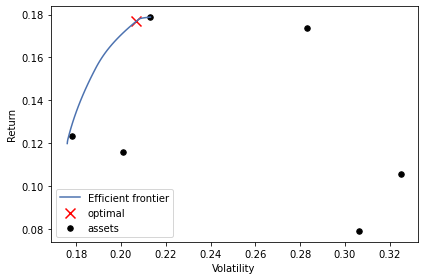

In [9]:
plotting.plot_efficient_frontier(cla)

### Tangency Portfolio

Tangency Portfolio는 CAL과 Frontier의 접점입니다. 수많은 투자 대상들을 다양한 방식으로 조합한 매우 효율적인 포트폴리오라고도 할 수 있습니다. Tagency Portfolio를 수식으로 표현하면 아래와 같습니다.

$$
E(r_i) = r_F + [E(r_M) - r_F]\beta_i,~~ where \beta_i = \frac{cov(r_i, r_M}{\sigma_M^2}
$$

- $E(r_i)$ : 임의의 종목 i의 수익률
- $E(r_M)$ : Tagency Portfolio의 수익률

직관적으로 해석하면 임의의 투자 종목은 시장 전체의 수익률의 흐름에 영향을 받는다는 것입니다.

In [17]:
ef = EfficientFrontier(mu, Sigma)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
tan_w = ef.max_sharpe()
print('Tangent Portfolio Weight : ', tan_w)
ef.portfolio_performance(verbose=True)

Tangent Portfolio Weight :  OrderedDict([('BSX', 0.268935910130012), ('AES', 0.0411661305172061), ('BRK-B', 0.1491153127668476), ('SEE', 0.0), ('QQQ', 0.3784264866564218), ('SPY', 0.1623561599295123)])
Expected annual return: 15.6%
Annual volatility: 19.5%
Sharpe Ratio: 0.70


(0.1560156300041013, 0.19468908395354032, 0.6986299757646373)

### 4. Optimizing Portfolio Allocation

**Min Volatility Portfolio**와 **Tagency Portfolio**의 경우 Allocation이 어떻게 되는지 시뮬레이션 해보고자 합니다.
전체 자산액 10000$가 있을 때 각각의 Portfolio의 자산 분배 현황을 나타내보겠습니다.

### Min Volatility Portfolio

In [19]:
latest_prices = discrete_allocation.get_latest_prices(data)

#Min Volatility Portfolio Allocation $10000
minvol_pwt = cla.min_volatility()
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio()

buy = 0
money = 10000.0
for k  in allocation_minv:
    buy += latest_prices[k] * allocation_minv[k]
print("Total Asset($) : ", money)
print("Total buy($) : ", buy, ", leftover($) :", money - buy)
print(allocation_minv)

Total Asset($) :  10000.0
Total buy($) :  9945.022644042969 , leftover($) : 54.97735595703125
{'BRK-B': 5, 'SEE': 6, 'SPY': 19}


### Tangency Portfolio

Tangency Portfolio에도 같은 방법을 사용하면 다음과 같습니다.

In [14]:
def print_orderdict(dict, postfix='%', space=8, title='', line=5):
    print(title)
    idx = 0
    for i in dict:
        idx += 1
        if postfix=='%':
            num = str(round(dict[i]*100, 2))
        else:
            num = str(dict[i])
        print(i.ljust(6), (num+postfix).rjust(space), end=" | ")
        if idx % line == 0:
            print()

In [16]:
latest_prices = discrete_allocation.get_latest_prices(data)
allocation_tan, rem_tan = discrete_allocation.DiscreteAllocation(tan_w, latest_prices, total_portfolio_value=20000).lp_portfolio()

buy = 0
money = 20000.0
for k  in allocation_tan:
    buy += latest_prices[k] * allocation_tan[k]
print("Total Asset($) : ", money)
print("Total buy($) : ", buy, ", leftover($) :", money - buy)
print_orderdict(allocation_tan, 
                postfix=" stk",
                title="** Optimal Weights **")

Total Asset($) :  20000.0
Total buy($) :  19983.460578918457 , leftover($) : 16.53942108154297
** Optimal Weights **
BSX     126 stk | AES      36 stk | BRK-B     9 stk | QQQ      24 stk | SPY       8 stk | 


## Conclusion

- pypfopt라는 라이브러리를 통해 Portfolio Optimization 및 Allocation을 실습해보았습니다.
- ML / DL Asset Allocation에 pypfopt 라이브러리의 가능성을 확인할 수 있었으며, Automatd Portfolio에 대한 프로젝트를 이어갈 계획입니다.